# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import i0
from numpy import exp, sin, cos
import seaborn as sns
import matplotlib as mpl
import os
from pathlib import Path
from statsFuncs import mean_confidence_interval
import scipy

mpl.rcParams['axes.linewidth'] = 2

# Paths

In [2]:
fig5_path = os.getcwd()
figures_path = str(Path(fig5_path).parent)
datapath = figures_path + '/data/naive_subjects/Analysis5_19_2020/'

# Plot params 

In [3]:
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['font.serif'] = 'Myriad Pro'
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.labelweight'] = 'medium'

# Subject loop 

In [4]:
files = folders = 0

for _, dirnames, filenames in os.walk(datapath):
  # ^ this idiom means "we won't be using this value"
    files += len(filenames)
    folders += len(dirnames)

print("{:,} files, {:,} folders".format(files, folders))
print(str(folders-1) + ' subjects')
nSubjects = folders-1

78 files, 13 folders
12 subjects


In [5]:
subject_names = ['AR', 'CK', 'CT', 'EW', 'HL', 'IS', 'JP', 'MF', 'NC', 'SK', 'SS']
nSubjects = len(subject_names)

## Calculate mean and errorr bars 

In [6]:
alldata_trimed = pd.DataFrame()
alldata = pd.DataFrame(columns=['SUBJECT', 'RUNNING_MEAN'])

row = 0
for subject in subject_names:
    print(subject)

    subjectdata_temp = pd.DataFrame()
    
    # load data:
    subjectdata_complete = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    
    subjectdata_temp['Running_Mean'] = subjectdata_complete['Running_Mean'].dropna()
    subjectdata_temp.loc[:, 'SUBJECT'] = subject
    
    alldata_trimed.loc[row,'SUBJECT'] = subject
    
    mean, sem_low, sem_up = mean_confidence_interval.mean_sem(subjectdata_temp['Running_Mean'])
    
    alldata_trimed.loc[row, 'AVERAGE_MEAN'] = mean
    alldata_trimed.loc[row, 'MEAN_SEM_LOW'] = sem_low
    alldata_trimed.loc[row, 'MEAN_SEM_UP'] = sem_up
    
    if subject == 'S1':
        alldata = subjectdata_temp
    else:
        alldata = pd.concat([alldata, subjectdata_temp])
    

    row += 1
    

AR
CK
CT
EW
HL
IS
JP
MF
NC
SK
SS


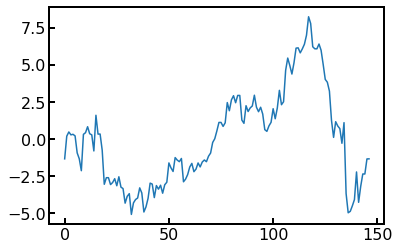

In [7]:
plt.plot(subjectdata_complete['Running_Mean'])

In [8]:
alldata = pd.DataFrame()

row = 0
for subject in subject_names:
    print(subject)

    subjectdata_temp = pd.DataFrame()
    
    # load data:
    subjectdata_complete = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    
    alldata[subject] = subjectdata_complete['Running_Mean'].dropna()
        


AR
CK
CT
EW
HL
IS
JP
MF
NC
SK
SS


In [9]:
for row in range(len(alldata)): # let's go calculating row by row
    mean, sem_low, sem_up = mean_confidence_interval.mean_sem(alldata.iloc[row, 0:nSubjects])
    alldata.loc[row, 'MEAN'] = mean
    alldata.loc[row, 'SEM_LOW'] = sem_low
    alldata.loc[row, 'SEM_UP'] = sem_up

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


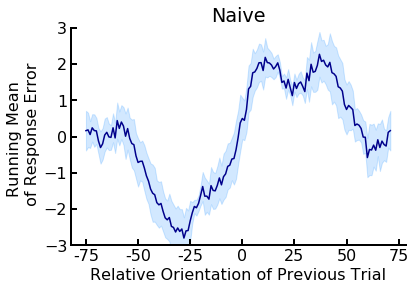

In [10]:
plt.plot(alldata['MEAN'], color='darkblue')
plt.fill_between(range(len(alldata)), alldata['SEM_LOW'], alldata['SEM_UP'], facecolor="orange", color='dodgerblue', alpha=0.2)
plt.ylabel('Running Mean \n of Response Error')
plt.xlabel('Relative Orientation of Previous Trial')
plt.ylim([-3, 3])
plt.yticks(np.arange(-3, 4, 1))
plt.xticks(np.arange(0, 151, 25), ('-75', '-50', '-25', '0', '25', '50', '75'))
sns.despine()
plt.title('Naive')
plt.savefig('AvgRunningMean_Naive.eps', bbox_inches='tight', dpi=1200)
plt.savefig('AvgRunningMean_Naive.jpg', bbox_inches='tight', dpi=1200)
plt.savefig('AvgRunningMean_Naive.svg', bbox_inches='tight', dpi=1200)

# Calculating running mean w/ diff step

In [11]:
def getRunningMean(stimuli_diff, filtered_responseError, halfway =73, step = 20):
    RM = [None] * (2 * halfway + 1); # running mean initialization
    xvals = list(range(-halfway, halfway + 1)) # index for running mean -90~90 + -90~90 (avoid error in sep[jj] == 91\92...
    allx_vals = xvals + xvals
    for ii in range(0,len(xvals) - 1): # start running mean calculation 0~180
        if ii - step // 2 >= 0:
            sep = allx_vals[(ii - step // 2) : (ii + step // 2 + 1)] # symmetric to avoid shift
        else:
            sep = allx_vals[(ii - step // 2) : len(allx_vals)] + allx_vals[0 : (ii + step // 2 + 1)]
        sep_sum = []
        for jj in range(0,len(sep)): # match every value in sep to every stimuli_diff point
            for kk in range(0, len(stimuli_diff)):
                if stimuli_diff[kk] == sep[jj]:
                    sep_sum.insert(0, filtered_responseError[kk])
        RM[ii] = np.mean(sep_sum)
    RM[2 * halfway] = RM[0]
    return RM, xvals

In [12]:
## IMPORTANT PARAMETERS:
step = 20

alldata_20 = pd.DataFrame()

row = 0
for subject in subject_names:
    print(subject)

    subjectdata_temp = pd.DataFrame()
    
    # load data:
    subjectdata_complete = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    
    filtered_data = subjectdata_complete[['Stim_diff', 'responseError']].dropna().reset_index(drop=True)
    
    RM, xvals = getRunningMean(filtered_data['Stim_diff'], filtered_data['responseError'], halfway=73, step = step)
    
    alldata_20[subject] = RM
        
for row in range(len(alldata_20)): # let's go calculating row by row
    
    mean, sem_low, sem_up = mean_confidence_interval.mean_sem(alldata_20.iloc[row, 0:nSubjects])
    alldata_20.loc[row, 'MEAN'] = mean
    alldata_20.loc[row, 'SEM_LOW'] = sem_low
    alldata_20.loc[row, 'SEM_UP'] = sem_up

AR
CK
CT
EW
HL
IS
JP
MF
NC
SK
SS


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


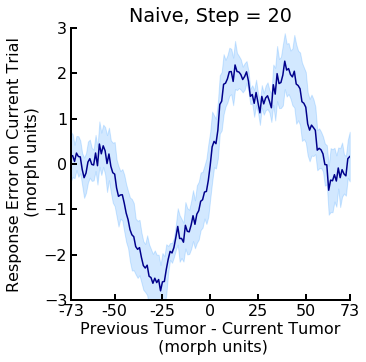

In [13]:
step = 20

plt.figure(figsize=(5, 5))
plt.plot(xvals, alldata_20['MEAN'], color='darkblue')
plt.fill_between(xvals, alldata_20['SEM_LOW'], alldata_20['SEM_UP'], facecolor="orange", color='dodgerblue', alpha=0.2)
plt.ylabel('Response Error on Current Trial\n (morph units)')
plt.xlabel('Previous Tumor - Current Tumor\n (morph units)')
plt.ylim([-3, 3])
plt.xlim([-73, 73])
plt.yticks(np.arange(-3, 4, 1))
plt.xticks([-73, -50, -25, 0, 25, 50, 73], ('-73', '-50', '-25', '0', '25', '50', '73'))
sns.despine()
plt.title('Naive, Step = ' + str(step))
plt.savefig('Step' + str(step) + '_AvgRunningMean_Naive.eps', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Naive.jpg', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Naive.svg', bbox_inches='tight', dpi=1200)

In [14]:
## IMPORTANT PARAMETERS:
step = 25

alldata_25 = pd.DataFrame()

row = 0
for subject in subject_names:
    print(subject)

    subjectdata_temp = pd.DataFrame()
    
    # load data:
    subjectdata_complete = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    
    filtered_data = subjectdata_complete[['Stim_diff', 'responseError']].dropna().reset_index(drop=True)
    
    RM, xvals = getRunningMean(filtered_data['Stim_diff'], filtered_data['responseError'], halfway=73, step = step)
    
    alldata_25[subject] = RM
        
for row in range(len(alldata_25)): # let's go calculating row by row
    
    mean, sem_low, sem_up = mean_confidence_interval.mean_sem(alldata_25.iloc[row, 0:nSubjects])
    alldata_25.loc[row, 'MEAN'] = mean
    alldata_25.loc[row, 'SEM_LOW'] = sem_low
    alldata_25.loc[row, 'SEM_UP'] = sem_up

AR
CK
CT
EW
HL
IS
JP
MF
NC
SK
SS


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


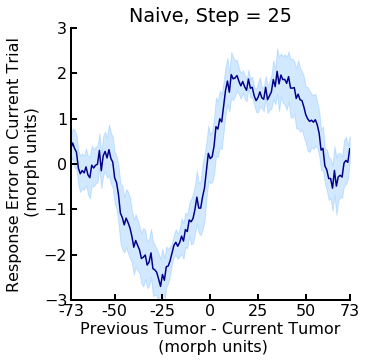

In [15]:
step = 25

plt.figure(figsize=(5, 5))
plt.plot(xvals, alldata_25['MEAN'], color='darkblue')
plt.fill_between(xvals, alldata_25['SEM_LOW'], alldata_25['SEM_UP'], facecolor="orange", color='dodgerblue', alpha=0.2)
plt.ylabel('Response Error on Current Trial\n (morph units)')
plt.xlabel('Previous Tumor - Current Tumor\n (morph units)')
plt.ylim([-3, 3])
plt.xlim([-73, 73])
plt.yticks(np.arange(-3, 4, 1))
plt.xticks([-73, -50, -25, 0, 25, 50, 73], ('-73', '-50', '-25', '0', '25', '50', '73'))
sns.despine()
plt.title('Naive, Step = ' + str(step))
plt.savefig('Step' + str(step) + '_AvgRunningMean_Naive.eps', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Naive.jpg', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Naive.svg', bbox_inches='tight', dpi=1200)

In [16]:
## IMPORTANT PARAMETERS:
step = 30

alldata_30 = pd.DataFrame()

row = 0
for subject in subject_names:
    print(subject)

    subjectdata_temp = pd.DataFrame()
    
    # load data:
    subjectdata_complete = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    
    filtered_data = subjectdata_complete[['Stim_diff', 'responseError']].dropna().reset_index(drop=True)
    
    RM, xvals = getRunningMean(filtered_data['Stim_diff'], filtered_data['responseError'], halfway=73, step = step)
    
    alldata_30[subject] = RM
        
for row in range(len(alldata_30)): # let's go calculating row by row
    
    mean, sem_low, sem_up = mean_confidence_interval.mean_sem(alldata_30.iloc[row, 0:nSubjects])
    alldata_30.loc[row, 'MEAN'] = mean
    alldata_30.loc[row, 'SEM_LOW'] = sem_low
    alldata_30.loc[row, 'SEM_UP'] = sem_up

AR
CK
CT
EW
HL
IS
JP
MF
NC
SK
SS


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


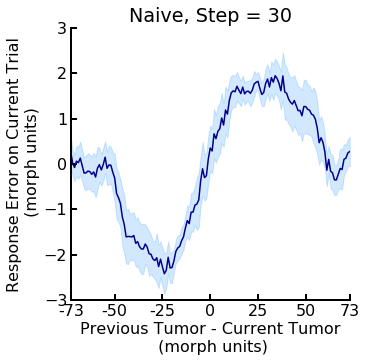

In [17]:
step = 30

plt.figure(figsize=(5, 5))
plt.plot(xvals, alldata_30['MEAN'], color='darkblue')
plt.fill_between(xvals, alldata_30['SEM_LOW'], alldata_30['SEM_UP'], facecolor="orange", color='dodgerblue', alpha=0.2)
plt.ylabel('Response Error on Current Trial\n (morph units)')
plt.xlabel('Previous Tumor - Current Tumor\n (morph units)')
plt.ylim([-3, 3])
plt.xlim([-73, 73])
plt.yticks(np.arange(-3, 4, 1))
plt.xticks([-73, -50, -25, 0, 25, 50, 73], ('-73', '-50', '-25', '0', '25', '50', '73'))
sns.despine()
plt.title('Naive, Step = ' + str(step))
plt.savefig('Step' + str(step) + '_AvgRunningMean_Naive.eps', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Naive.jpg', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Naive.svg', bbox_inches='tight', dpi=1200)

In [18]:
## IMPORTANT PARAMETERS:
step = 35

alldata_35 = pd.DataFrame()

row = 0
for subject in subject_names:
    print(subject)

    subjectdata_temp = pd.DataFrame()
    
    # load data:
    subjectdata_complete = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    
    filtered_data = subjectdata_complete[['Stim_diff', 'responseError']].dropna().reset_index(drop=True)
    
    RM, xvals = getRunningMean(filtered_data['Stim_diff'], filtered_data['responseError'], halfway=73, step = step)
    
    alldata_35[subject] = RM
        
for row in range(len(alldata_35)): # let's go calculating row by row
    
    mean, sem_low, sem_up = mean_confidence_interval.mean_sem(alldata_35.iloc[row, 0:nSubjects])
    alldata_35.loc[row, 'MEAN'] = mean
    alldata_35.loc[row, 'SEM_LOW'] = sem_low
    alldata_35.loc[row, 'SEM_UP'] = sem_up

AR
CK
CT
EW
HL
IS
JP
MF
NC
SK
SS


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


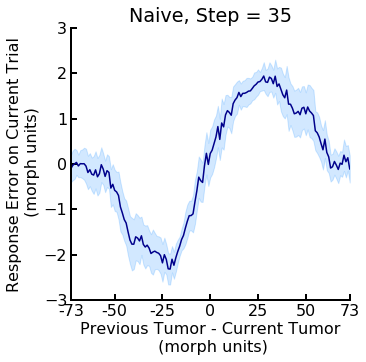

In [19]:
step = 35

plt.figure(figsize=(5, 5))
plt.plot(xvals,alldata_35['MEAN'], color='darkblue')
plt.fill_between(xvals, alldata_35['SEM_LOW'], alldata_35['SEM_UP'], facecolor="orange", color='dodgerblue', alpha=0.2)
plt.ylabel('Response Error on Current Trial\n (morph units)')
plt.xlabel('Previous Tumor - Current Tumor\n (morph units)')
plt.ylim([-3, 3])
plt.xlim([-73, 73])
plt.yticks(np.arange(-3, 4, 1))
plt.xticks([-73, -50, -25, 0, 25, 50, 73], ('-73', '-50', '-25', '0', '25', '50', '73'))
sns.despine()
plt.title('Naive, Step = ' + str(step))
plt.savefig('Step' + str(step) + '_AvgRunningMean_Naive.eps', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Naive.jpg', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Naive.svg', bbox_inches='tight', dpi=1200)